# Titanic Modeling, Evaluation and Deployment

## CRISP-DM

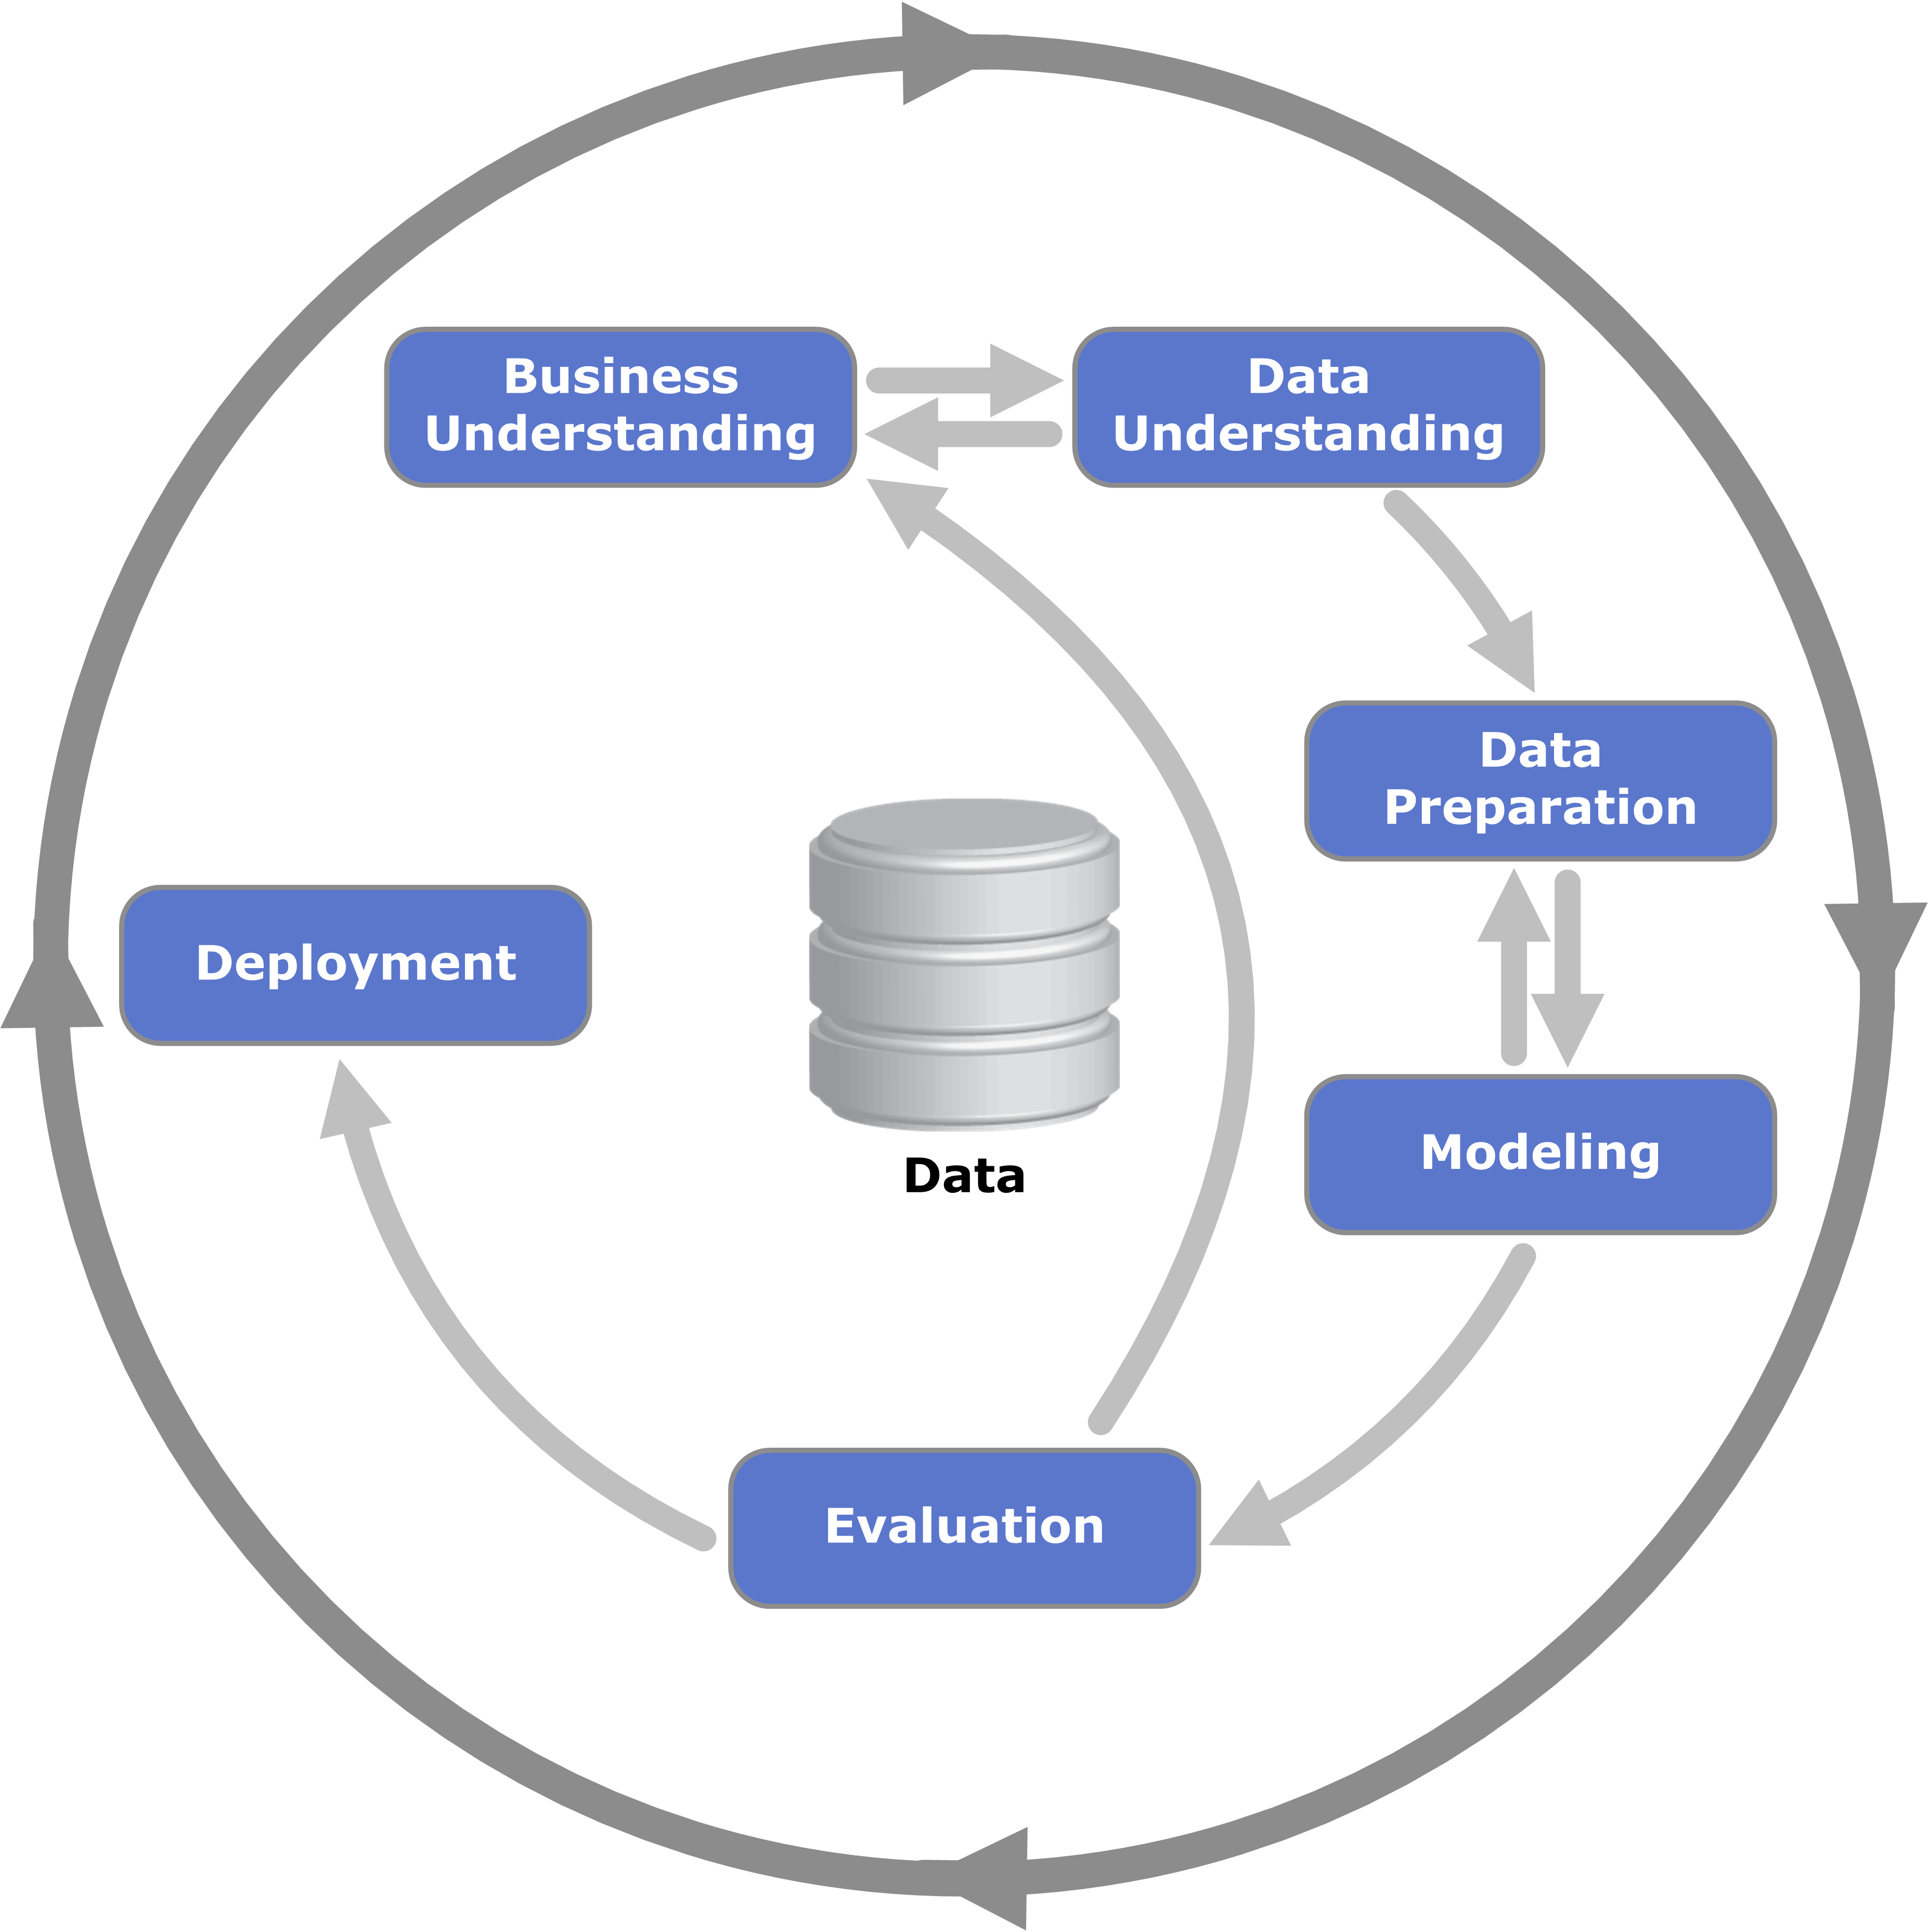

In [92]:
from IPython import display
display.Image('https://upload.wikimedia.org/wikipedia/commons/b/b9/CRISP-DM_Process_Diagram.png', width=500)

## Import relevant packages

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

## Load data and prepare for modeling

Data preparation for modeling (including 'pd.get_dummies') has been performed in the previous notebook. Now, data are imported again and split into training and test. Models are built on training data only and, afterwards, evaluated on (previously unseen) test data. 

Attention: Reading and writing files is slightly different between Local and Cloud. You can click on the 0100 icon in the upper right corner, locate the file and then click "Insert to code". 

In [94]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0


cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='JAeQqPIC1_tAM-oIUtedUVCMLJ1aNCzBN7dtbSCYBPLU',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'hhzdbmsose2023-donotdelete-pr-acduumolcsemoz'
object_key = 'train_dummies.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

In [95]:
# Local
# df_dummies = pd.read_csv('train_dummies.csv') # use full path if notebook and file in different folders! 

# Cloud: Fetch the file
# insert to code

df_dummies = pd.read_csv(body)

In [96]:
df_dummies.head()

Survived  Pclass  Family  Sex_male  Embarked_Q  Embarked_S  AgeRange_10-20  \
0         0       3       2         1           0           1               0   
1         1       1       2         0           0           0               0   
2         1       3       1         0           0           1               0   
3         1       1       2         0           0           1               0   
4         0       3       1         1           0           1               0   

   AgeRange_20-30  AgeRange_30-40  AgeRange_40-50  AgeRange_50-60  \
0               1               0               0               0   
1               0               1               0               0   
2               1               0               0               0   
3               0               1               0               0   
4               0               1               0               0   

   AgeRange_60-70  AgeRange_70-80  FareRange_Q2  FareRange_Q3  FareRange_Q4  
0               0               0             0             0             0  
1               0               0             0             0             1  
2               0               0             0             0             0  
3               0               0             0             0             1  
4               0               0             0             0             0

In [97]:
target = df_dummies['Survived'] # feature to be predicted
predictors = df_dummies.drop(['Survived'], axis = 1) # all other features are used as predictors

In [98]:
predictors.head()

Pclass  Family  Sex_male  Embarked_Q  Embarked_S  AgeRange_10-20  \
0       3       2         1           0           1               0   
1       1       2         0           0           0               0   
2       3       1         0           0           1               0   
3       1       2         0           0           1               0   
4       3       1         1           0           1               0   

   AgeRange_20-30  AgeRange_30-40  AgeRange_40-50  AgeRange_50-60  \
0               1               0               0               0   
1               0               1               0               0   
2               1               0               0               0   
3               0               1               0               0   
4               0               1               0               0   

   AgeRange_60-70  AgeRange_70-80  FareRange_Q2  FareRange_Q3  FareRange_Q4  
0               0               0             0             0             0  
1               0               0             0             0             1  
2               0               0             0             0             0  
3               0               0             0             0             1  
4               0               0             0             0             0

In [99]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=123) # 80-20 split into training and test data

In [100]:
# Check data balancing
y_train.value_counts()

# There is no severe skew in the class distribution. No resampling needed. 
# If you want to learn more about resampling, also check https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

0    337
1    234
Name: Survived, dtype: int64

## Create and evaluate classification models

Predicting whether a pasenger on the Titanic survived or not is a supervised machine learning problem. Some commonly used algorithms include decision trees, random forest and logistic regression. Once a classification model has been built, evaluation metrics are calculated and interpreted. 

### Decision Tree

In [101]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [102]:
confusion_matrix(y_test, tree.predict(X_test)) # yields count of true negatives, false positives, false negatives, true positives

array([[75, 12],
       [22, 34]])

In [103]:
tn, fp, fn, tp = confusion_matrix(y_test, tree.predict(X_test)).ravel() # check that tp, fp, tn, fn are not confused
print(tn, fp, fn, tp)

75 12 22 34


In [104]:
print(classification_report(y_train, tree.predict(X_train))) # yields class-specific precision, recall and f1-score

              precision    recall  f1-score   support

           0       0.87      0.97      0.91       337
           1       0.95      0.78      0.86       234

    accuracy                           0.89       571
   macro avg       0.91      0.88      0.89       571
weighted avg       0.90      0.89      0.89       571



In [105]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.86      0.82        87
           1       0.74      0.61      0.67        56

    accuracy                           0.76       143
   macro avg       0.76      0.73      0.74       143
weighted avg       0.76      0.76      0.76       143



Performance on test data is significantly lower than on training data. Probably the decision tree overfits on training data and does not generalize well on unseen test data. 

In [106]:
list(zip(X_train.columns, tree.feature_importances_)) # lists features and their importance in predicting the target

[('Pclass', 0.16097785712827323),
 ('Family', 0.08697392036164474),
 ('Sex_male', 0.4384561832848728),
 ('Embarked_Q', 0.00795303493124926),
 ('Embarked_S', 0.032064415881252396),
 ('AgeRange_10-20', 0.03857811745000412),
 ('AgeRange_20-30', 0.030490625160037),
 ('AgeRange_30-40', 0.04297848255913459),
 ('AgeRange_40-50', 0.039192322510561074),
 ('AgeRange_50-60', 0.033166119231976786),
 ('AgeRange_60-70', 0.01698979089571839),
 ('AgeRange_70-80', 0.003122373784700891),
 ('FareRange_Q2', 0.028740613664951776),
 ('FareRange_Q3', 0.03437367510792124),
 ('FareRange_Q4', 0.005942468047701615)]

### Random Forest

In [107]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [108]:
confusion_matrix(y_test, rf.predict(X_test))

array([[77, 10],
       [17, 39]])

In [109]:
print(classification_report(y_train, rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       337
           1       0.91      0.82      0.86       234

    accuracy                           0.89       571
   macro avg       0.90      0.88      0.89       571
weighted avg       0.89      0.89      0.89       571



In [110]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        87
           1       0.80      0.70      0.74        56

    accuracy                           0.81       143
   macro avg       0.81      0.79      0.80       143
weighted avg       0.81      0.81      0.81       143



As before, test performance is lower than training performance. Random forests, too, can suffer from overfitting on training data. 

In [111]:
list(zip(X_train.columns, rf.feature_importances_))

[('Pclass', 0.16005425371027457),
 ('Family', 0.1528199464664282),
 ('Sex_male', 0.3338763687311535),
 ('Embarked_Q', 0.012197120824852128),
 ('Embarked_S', 0.05211415268604683),
 ('AgeRange_10-20', 0.028979297457740208),
 ('AgeRange_20-30', 0.04152790636051713),
 ('AgeRange_30-40', 0.03906798082150902),
 ('AgeRange_40-50', 0.030451404928458846),
 ('AgeRange_50-60', 0.015468818587328487),
 ('AgeRange_60-70', 0.016411422194417647),
 ('AgeRange_70-80', 0.004435850060856585),
 ('FareRange_Q2', 0.03045490020108576),
 ('FareRange_Q3', 0.03688888395560094),
 ('FareRange_Q4', 0.04525169301373001)]

### Logistic Regression

In [112]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [113]:
print(confusion_matrix(y_test, logreg.predict(X_test)))

[[71 16]
 [17 39]]


Text(0.5, 43.249999999999986, 'Predicted label')

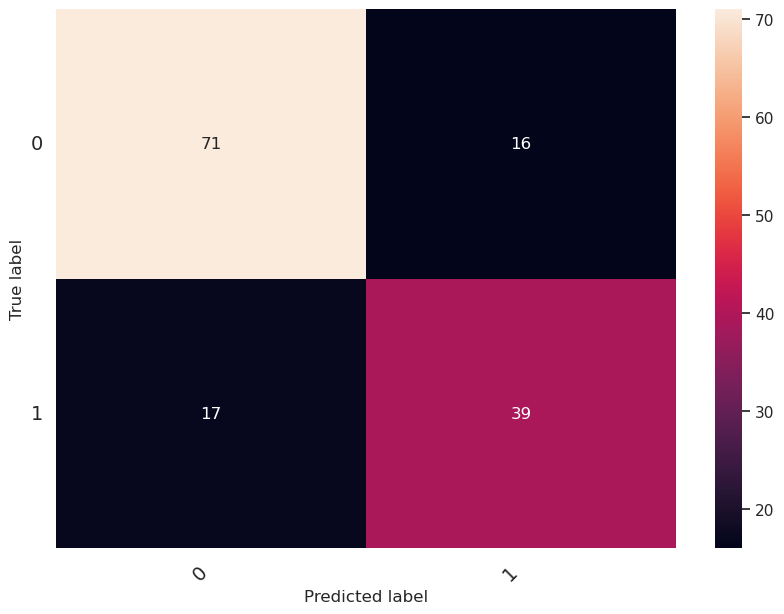

In [114]:
# nicer way to inspect confusion matrix
conf_mat = confusion_matrix(y_test, logreg.predict(X_test))
df_cm = pd.DataFrame(conf_mat, index=['0','1'], columns=['0', '1'],)
fig = plt.figure(figsize=[10,7])
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [115]:
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81        87
           1       0.71      0.70      0.70        56

    accuracy                           0.77       143
   macro avg       0.76      0.76      0.76       143
weighted avg       0.77      0.77      0.77       143



In [116]:
print(classification_report(y_train, logreg.predict(X_train)))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       337
           1       0.77      0.73      0.75       234

    accuracy                           0.80       571
   macro avg       0.79      0.79      0.79       571
weighted avg       0.80      0.80      0.80       571



For logistic regression, training and test performance are very similar. This probably means that the created model generalizes well on new data. 

### Building many models

When building and comparing lots of models, it may be useful to loop over several classifiers or over one classifier with several parameters. An idea to overcome the overfitting problem with tree-based classifiers is to limit the depth of trees and inspect evaluation metrics.

In [117]:
# vary maximum tree depth for random forest
tree_depth = [5, 10, 20]
for i in tree_depth:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(X_train, y_train)
    print('Max tree depth: ', i)
    print('Train results: ', classification_report(y_train, rf.predict(X_train)))
    print('Test results: ',classification_report(y_test, rf.predict(X_test)))

Max tree depth:  5
Train results:                precision    recall  f1-score   support

           0       0.82      0.91      0.86       337
           1       0.85      0.72      0.78       234

    accuracy                           0.83       571
   macro avg       0.84      0.81      0.82       571
weighted avg       0.83      0.83      0.83       571

Test results:                precision    recall  f1-score   support

           0       0.80      0.91      0.85        87
           1       0.82      0.64      0.72        56

    accuracy                           0.80       143
   macro avg       0.81      0.78      0.78       143
weighted avg       0.81      0.80      0.80       143

Max tree depth:  10
Train results:                precision    recall  f1-score   support

           0       0.90      0.92      0.91       337
           1       0.88      0.85      0.87       234

    accuracy                           0.89       571
   macro avg       0.89      0.89      0.8

Feel free to consider additional aspects if you are familiar with machine learning: You could check for class imbalance and mitigate this by oversampling training data. You could also try more classification algorithms like SVM. 

# Titanic Deployment

In this section you will learn how to deploy a scikit-learn model as a web service with the aid of the _IBM Watson Machine Learning Service_.

## Local Prediction

First, choose the model to deploy and make a local prediction. Later, you will compare the predicted results returned by the local model with the results returned by the web service for evaluation purposes. 

In [118]:
# assign your favorite model to the deployment_classifier variable
deployment_classifier = logreg
deployment_classifier

LogisticRegression()

In [119]:
# recap: print first rows of training data
df_dummies.head(2)

Survived  Pclass  Family  Sex_male  Embarked_Q  Embarked_S  AgeRange_10-20  \
0         0       3       2         1           0           1               0   
1         1       1       2         0           0           0               0   

   AgeRange_20-30  AgeRange_30-40  AgeRange_40-50  AgeRange_50-60  \
0               1               0               0               0   
1               0               1               0               0   

   AgeRange_60-70  AgeRange_70-80  FareRange_Q2  FareRange_Q3  FareRange_Q4  
0               0               0             0             0             0  
1               0               0             0             0             1

In [120]:
# recap: print first rows of predictors (here: training data without predicted column "Survived")
predictors.head(2)

Pclass  Family  Sex_male  Embarked_Q  Embarked_S  AgeRange_10-20  \
0       3       2         1           0           1               0   
1       1       2         0           0           0               0   

   AgeRange_20-30  AgeRange_30-40  AgeRange_40-50  AgeRange_50-60  \
0               1               0               0               0   
1               0               1               0               0   

   AgeRange_60-70  AgeRange_70-80  FareRange_Q2  FareRange_Q3  FareRange_Q4  
0               0               0             0             0             0  
1               0               0             0             0             1

In [121]:
# use the local model to make a prediction for the first two passengers
deployment_classifier.predict(predictors.iloc[0:2])

array([0, 1])

Review the output. Did the model return a correct prediction for the "Survived" field?

## Web service deployment

To work through this section, you need
- a Watson Machine Learning instance
- an IBM Cloud API key
- a deployment space id

Check the guidelines available at https://github.com/ellenhvn/hhz-artificial-intelligence-vl-ws22/tree/main/Guidelines for details.

In [122]:
# import Python client library (documentation available at http://ibm-wml-api-pyclient.mybluemix.net/)
from ibm_watson_machine_learning import APIClient

In [123]:
# set your IBM Cloud API key 
api_key = "JAeQqPIC1_tAM-oIUtedUVCMLJ1aNCzBN7dtbSCYBPLU"

# set the URL of your WML instance 
# depending on the region you chose during instance creation it will take one of the below values:
# - Frankfurt: https://eu-de.ml.cloud.ibm.com
# - Dallas: https://us-south.ml.cloud.ibm.com
# - London: https://eu-gb.ml.cloud.ibm.com
# - Tokyo: https://jp-tok.ml.cloud.ibm.com
wml_url = "https://us-south.ml.cloud.ibm.com"

In [124]:
# setup the API client
wml_client = APIClient({
   "url": wml_url,
   "apikey": api_key
})

In [125]:
# list all existing deployment spaces
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -----------------  ------------------------
ID                                    NAME               CREATED
1a3fe099-f3ed-40b3-be00-126582acf359  HHZ DBM SoSe 2023  2023-04-14T07:26:21.505Z
------------------------------------  -----------------  ------------------------


ID               NAME  \
0  1a3fe099-f3ed-40b3-be00-126582acf359  HHZ DBM SoSe 2023   

                    CREATED  
0  2023-04-14T07:26:21.505Z

In [126]:
# set the id of the deployment space you want to use as default
wml_client.set.default_space("1a3fe099-f3ed-40b3-be00-126582acf359")

'SUCCESS'

In [127]:
# setup required properties to store the model
sofware_spec_uid = wml_client.software_specifications.get_id_by_name("runtime-22.2-py3.10")
metadata = {
            wml_client.repository.ModelMetaNames.NAME: 'Titanic Model_FZ',
            wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.1',
            wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}
metadata

{'name': 'Titanic Model_FZ',
 'type': 'scikit-learn_1.1',
 'software_spec': 'b56101f1-309d-549b-a849-eaa63f77b2fb'}

In [128]:
# store the scikit-learn model in WML
model = wml_client.repository.store_model(deployment_classifier, meta_props=metadata)

In [129]:
# review available models in your WML instance
wml_client.repository.list()

------------------------------------  ---------------------------  ------------------------  ----------------  -----  ----------  ----------------
GUID                                  NAME                         CREATED                   FRAMEWORK         TYPE   SPEC_STATE  SPEC_REPLACEMENT
4195b6fd-e2db-407d-b60f-9c3f31987634  Titanic Model_FZ             2023-05-22T12:14:31.002Z  scikit-learn_1.1  model  supported
c096e6b9-2eb9-447e-a7d1-ded4fdcb78f6  Titanic Model                2023-05-22T12:11:10.002Z  scikit-learn_1.1  model  supported
d4415011-50fa-4e03-946e-86c94e3c7637  Titanic Model                2023-05-22T12:11:06.002Z  scikit-learn_1.1  model  supported
0af0c45c-3e52-420b-b9ff-0dac30579cf6  Titanic Model                2023-05-22T12:07:19.002Z  scikit-learn_1.1  model  supported
b53dd673-1a8a-44f7-8361-eb3ca77bcd0e  Titanic Model                2023-05-22T12:01:56.002Z  scikit-learn_1.1  model  supported
31144db3-1611-4237-91f4-1a63d7ffb35b  Titanic Model               

In [130]:
# retrieve the id of the model you deployed
published_model_uid = wml_client.repository.get_model_id(model)
published_model_uid

'4195b6fd-e2db-407d-b60f-9c3f31987634'

In [131]:
# setup required properties to deploy the model
metadata = {
    wml_client.deployments.ConfigurationMetaNames.NAME: "Deployment of Titanic model",
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}


In [132]:
# deploy the model as a web service (an API endpoint is generated for your deployment so your tools and apps can use a REST API to send data to your deployed model for analysis)
created_deployment = wml_client.deployments.create(published_model_uid, name="Titanic Deployment", meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '4195b6fd-e2db-407d-b60f-9c3f31987634' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='a505f847-c359-4f10-bb46-4ae4221347e7'
------------------------------------------------------------------------------------------------




In [133]:
# keep the REST API endpoint for evaluation
scoring_endpoint = wml_client.deployments.get_scoring_href(created_deployment)
scoring_endpoint

'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/a505f847-c359-4f10-bb46-4ae4221347e7/predictions'

Now check the deployment spaces UI (open the menu on the side menu, select "View all spaces" and navigate to the selected space).
- Can you find your model and deployment?
- Can you find code snippets to share with developers that will enable them to make predictions using your web service deployment?

## Evaluate web service deployment

You will now use the REST API (documentation available at https://cloud.ibm.com/apidocs/machine-learning#deployments-compute-predictions) to execute a prediction and compare its results against the local prediction from a previous section.

In [134]:
# import requests module
import requests

In [135]:
# setup the request payload as per the API documentation
scoring_values = predictors.iloc[0:2].to_numpy().tolist()
payload_scoring = {"input_data": [{"values": scoring_values}]}

In [ ]:
# create a token to make an authenticated request
token_response = requests.post('https://iam.eu-de.bluemix.net/identity/token', data={"apikey": api_key, "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'})
mltoken = token_response.json()["access_token"]


In [ ]:
# send the scoring request
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}
response_scoring = requests.post(f'{scoring_endpoint}?version=2022-04-29', json=payload_scoring, headers={'Authorization': 'Bearer ' + mltoken})
response_scoring.content

- Do the results match the predictions executed in this notebook?
- What information does the response payload include in addition to the classification?

## Clean up

Free WML instances only allow for a limited number of models and deployments. Let's clean up artefacts that are no longer needed.

In [ ]:
# list deployments
wml_client.deployments.list()

In [ ]:
# delete deployments you just created 
wml_client.deployments.delete("...")

In [ ]:
# list models
wml_client.repository.list_models()

In [ ]:
# delete models you just created
wml_client.repository.delete("...")